# 机器学习 实验五 层次聚类

- 专业：物联网工程
- 姓名：秦泽斌
- 学号：2212005

## 一、实验要求
1. **初级要求：**

- 实现single-linkage层次聚类算法
- 实现complete-linkage层次聚类算法
  
2. **中级要求：**

- 实现average-linkage层次聚类算法
- 将上述三种算法的性能进行简要对比

3. **高级要求：**

- 通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析

## 二、 实验内容

### 导入需要的库

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets._samples_generator import make_blobs
%matplotlib inline  
MAX_NUM = 1e3

### 1. 初级要求
#### （1）实现single-linkage层次聚类算法
最短距离 / 单连接 (single linkage):类 Gp 的样本与 Gq 的样本之间的最短距离<br/>
$D_{pq} = min\{d_{ij}|x_i \in G_p, x_j \in G_q\}$


In [2]:
def singleLinkage(X,_):
    return np.min(X, axis=0)

#### （2）实现complete-linkage层次聚类算法
最⻓距离 / 全连接 (complete linkage): 类 Gp 的样本与 Gq 样本之间的最⻓距离<br/>
$D_{pq} = max\{d_{ij}|x_i \in G_p, x_j \in G_q\}$

In [3]:
def completeLinkage(X,_):
    return np.max(X, axis=0)

### 2. 中级要求
#### （1）实现average-linkage层次聚类算法
平均距离 (average linkage): 类 Gp 与 Gq 任意两个样本之间距离的平均值<br/>
$D_{pq} = \frac{1}{n_pn_q}\sum_{x_i \in G_p}\sum_{x_j \in G_q} d_{ij}$


In [4]:
def averageLinkage(X, num):
    return np.average(X, axis=0, weights = num)

#### （2）将上述三种算法的性能进行简要对比

##### 2.2.1 实现聚类过程

In [5]:
class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        self.dataCnt = datas.shape[0]
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            # 聚类间距离矩阵更新
            modify = method(clusterDist[[dest,src]],(len(setList[dest]),len(setList[src])))
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
            if (self.dataCnt - clusterCount) % (self.dataCnt / 4) == 0:
                print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

##### 2.2.2 生成数据

In [6]:
def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

##### 2.2.3 绘制二维图像

In [8]:
def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,name =data
    fig=plt.figure(figsize=(3,3),dpi=100)
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)
    plt.title(name)
    plt.show()

##### 2.2.4 绘制三维图像

In [7]:
def plot_3D(*data):
    X,labels_true,labels_predict,name =data
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],X[i,2], color=colors[predict%len(colors)],s=np.pi)
    plt.title(name)
    plt.show()

##### 2.2.5 进行算法性能比较 

generate data finish!
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !


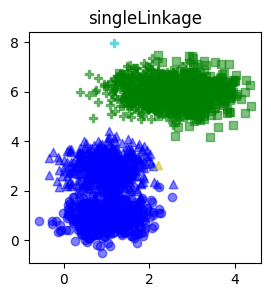

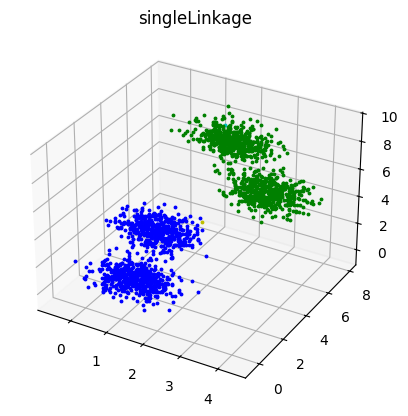

--------------------Segmentation--------------------
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !


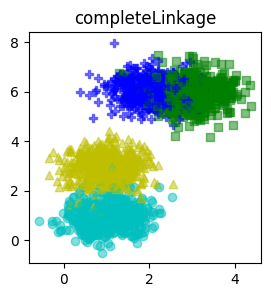

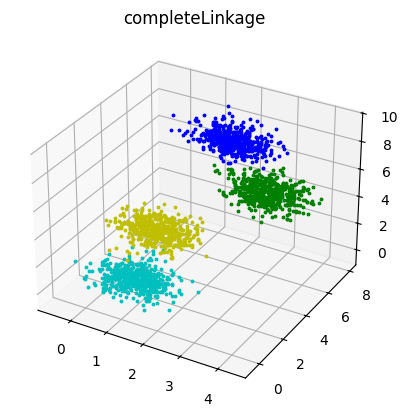

--------------------Segmentation--------------------
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !


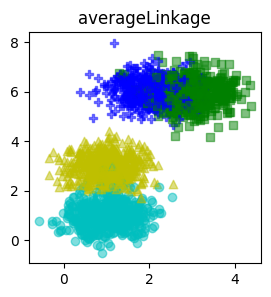

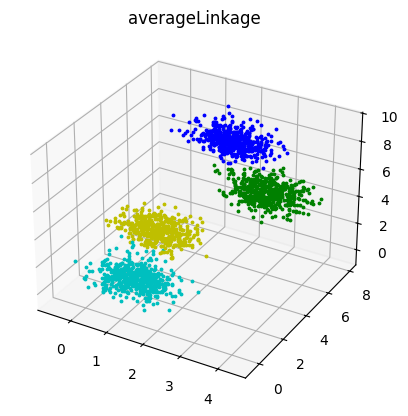

--------------------Segmentation--------------------


In [9]:
centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('data.dat',X)
np.savetxt('label.dat',labels_true)
print("generate data finish!")

title = ['singleLinkage','completeLinkage','averageLinkage']
METHOD_APPLY = [singleLinkage,completeLinkage,averageLinkage]
k=4
pre_label=[]  # 保存预测类别
for i, method in enumerate(METHOD_APPLY):
    model = AgglomerativeClustering()
    model.fit(X,method)
    plot_data(X,labels_true,model.label(k),title[i])
    pre_label.append(model.label(k))
    plot_3D(X,labels_true,model.label(k),title[i])
    print("--------------------Segmentation--------------------")

##### 2.2.6 性能评价

**此处通过调整兰德系数（AIR）和轮廓系数来进行聚类性能评价**
- 轮廓系数的值是介于 [-1,1] ，越趋近于1代表内聚度和分离度都相对较优。
- ARI 取值范围为 [-1,1]，值越大意味着聚类结果与真实情况越吻合。从广义的角度来讲，ARI 衡量的是两个数据分布的吻合程度。

In [10]:
import sklearn.metrics
print("聚类轮廓系数为：") 
for i ,label in enumerate(pre_label):
    print("{}：{}".format(title[i], sklearn.metrics.silhouette_score(X, label, sample_size=len(X), metric='euclidean')))
print("兰德系数为：") 
for i ,label in enumerate(pre_label):
    print("{}：{}".format(title[i], sklearn.metrics.adjusted_rand_score(labels_true, label)))

聚类轮廓系数为：
singleLinkage：0.20552255842384334
completeLinkage：0.6290623072083128
averageLinkage：0.629042693970197
兰德系数为：
singleLinkage：0.49912503082022047
completeLinkage：0.988090134216283
averageLinkage：0.9867810442334484



通过上述实验，我们可以明显的看出，使用average-linkage算法的实验结果明显优于使用signle-linkage和complete-linkage算法的实验结果。可以得出结论：

- SingleLinkage 这种以最小值为距离度量标准的计算方式导致两个cluster 明明从“大局”上离得比较远，但是由于其中个别的点距离比较近就被合并了，并且这样合并之后 Chaining 效应会进一步扩大，最后会得到比较松散的cluster。因此，single linkage 的极差表现也就变得可以理解了。
- CompleteLinkage对于离群点处理能力不足，会导致两个 cluster 即使已经很接近了，但是只要有不配合的点存在，就不会合并。这两种相似度的定义方法的共同问题就是指考虑了某个有特点的数据，而没有考虑类内数据的整体特点。
- Average-linkage：这种方法就是把两个集合中的点两两的距离全部放在一起求一个平均值，相对也能得到合适一点的结果。考虑了整体情况，不会因为某些极端值或边界上的点影响整体结果。

### 3. 高级要求
#### 通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析

In [11]:
centers_total=[[1,1,1],[1,3,3],[3,6,5],[2,6,8],[2,2,2],[8,0,0],[5,5,5],[7,8,1],[3,3,3]]
k_total = range(2,10)
silhouette_total = []
adjusted_rand_total = []
colors='rby'
print("不同算法不同k值轮廓系数对比:")
for i, method in enumerate(METHOD_APPLY):
    silhouette_temp = []
    adjusted_rand_temp = []
    for k in k_total:
        centers = centers_total[:k]
        X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
        model = AgglomerativeClustering()
        model.fit(X, method)
        pre_label = model.label(k)
        score1 = sklearn.metrics.adjusted_rand_score(labels_true, pre_label)
        score2 = sklearn.metrics.silhouette_score(X, pre_label, sample_size=len(X), metric='euclidean')
        silhouette_temp.append(score2)
        adjusted_rand_temp.append(score1)
        print("{}-{}：兰德系数——{}   轮廓系数——{}".format(title[i],k,score1,score2))
    silhouette_total.append(silhouette_temp)
    adjusted_rand_total.append(adjusted_rand_temp)

不同算法不同k值轮廓系数对比:
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !
singleLinkage-2：兰德系数——0.0   轮廓系数——0.1959443020949702
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !
singleLinkage-3：兰德系数——0.5700823599400583   轮廓系数——0.5608801283974062
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !
singleLinkage-4：兰德系数——0.4991262838267789   轮廓系数——0.3643975668039684
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !
singleLinkage-5：兰德系数——0.4817239292506097   轮廓系数——0.367321590537312
calculate distance finish!
calculate cluster distance finish!
1500  clusters left.
1000  clusters left.
500  clusters left.
cluster finish !
singleLinkage-6：兰德系数——0

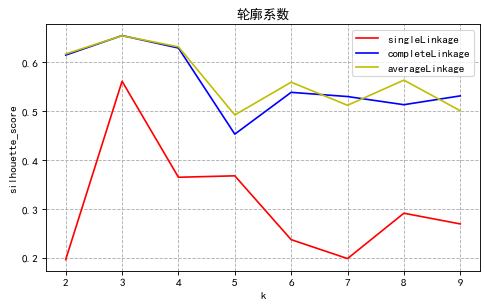

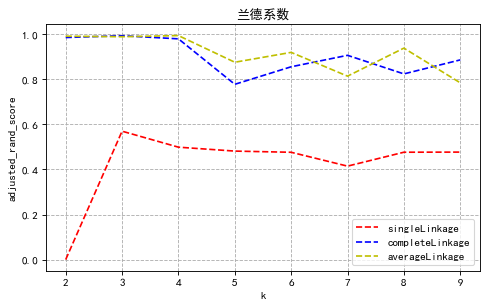

In [12]:
plt.rcParams['font.sans-serif']=['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(7,4),dpi=80)
for i in range(len(METHOD_APPLY)):
    plt.plot(k_total,silhouette_total[i],color=colors[i],linestyle='-',label=title[i])
plt.legend()
plt.grid(linestyle="--")
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.title('轮廓系数')
plt.show()

plt.figure(figsize=(7,4),dpi=80)
for i in range(len(METHOD_APPLY)):
    plt.plot(k_total,adjusted_rand_total[i],color=colors[i],linestyle='--',label=title[i])
plt.legend()
plt.grid(linestyle="--")
plt.xlabel("k")
plt.ylabel("adjusted_rand_score")
plt.title('兰德系数')
plt.show()

通过上图可以观察到：SingleLinkage层次聚类效果最差，而且波动性相对最强，随着聚类个数越多，通过轮廓系数可以看出AverageLinkage层次聚类对于类间分离程度和类内紧致性表现最好，通过兰德系数可以看出AverageLinkage和CompleteLinkage层次聚类算法对于聚类准确性上来说更稳定